In [1]:
from backtester.core import *
from backtester.performance import *
from market.preprocessing import *
from pricing.positions import *

from datetime import date

In [ ]:
class CallOverwriteStrategy(Backtester):
    def __init__(self, universe, start_date, end_date, starting_balance):
        super().__init__(universe, start_date, end_date, starting_balance)

        self.indicator_symbols = 'ctp1'
        self.indicator_values = {}
        self.sma_period = 50
        self.sma_spread = 0.1
        self.otm_pctg = 0.1 # 20%
        self.option_maturity = 30 # days
        self.option_quantity = 100
        self.all_history_prices = history_to_dataframe(self.available_market_data)

        @self.indicator.register("SMA")
        def distance_moving_average(prices: pd.Series):
            ema50 = prices.rolling(window = self.sma_period).mean()
            ema50_distance = (prices - ema50)/prices
            return ema50_distance
        
        self._precompute_indicators()

    def _precompute_indicators(self):
        for key in list(self.indicator.methods.keys()):
            self.indicator_values[key] = pd.DataFrame(self.indicator.compute(key, self.all_history_prices[self.indicator_symbols]))

    def on_data(self):
        # aggiungere condizione per posizione aperta nello stesso mese-anno
        # controllare estrapolazione matrice di vol, stampare strike e time dell'errore e replicare
        ref_date = self.ref_dates[-1] 
        # month_index = ref_date.month
        mkt = self.history[ref_date]
        ctp1_price = self.history[ref_date]['equity']['ctp1']['price']

        sma_50_spread = self.indicator_values['SMA']['ctp1'].loc[:ref_date]

        if sma_50_spread.iloc[-1] > self.sma_spread and sma_50_spread.iloc[-2] < self.sma_spread:
            
            opt_position = OptionPosition(symbol='ctp1',
                            quantity=self.option_quantity,
                            market_data=mkt,
                            strike_price= ctp1_price * (1 + self.otm_pctg),
                            expiry_date=ref_date + timedelta(days=self.option_maturity),
                            option_type=OptionType.CALL, position_type=PositionType.SHORT)
            self.portfolio.add_position(opt_position)

    def buy(self, position: Position):
        if self.margin > position.quantity * position.entry_price:
            self.portfolio.add_position(position)
            self.margin = self.margin - position.quantity * position.entry_price
        else:
            print("No margin available for position")
    

In [11]:
universe = ['ctp1']
start_date = date(2022, 10, 14)
end_date = date(2023, 10, 12)
starting_balance = 1000

backtester = CallOverwriteStrategy(universe, start_date, end_date, starting_balance)
backtester.backtest()

res = ResultAnalyzer(backtester.positions_summary, backtester.period_pnl)

In [12]:
backtester.period_pnl

,ref_date,daily_pnl
0,2023-01-31,1000.000000
1,2023-02-01,999.655062
2,2023-02-02,1000.207081
3,2023-02-03,1000.805317
4,2023-02-06,1000.355154
...,...,...
174,2023-10-06,1001.438148
175,2023-10-09,1001.438148
176,2023-10-10,1001.438148
177,2023-10-11,1001.438148


In [13]:
res.get_trade_log()

,ref_date,trade_date,trade_id,symbol,type,side,quantity,entry_price,is_alive,current_value,open_pnl,closed_pnl,global_pnl
0,2023-01-31,2023-01-31,79691,ctp1,option,-1,100,0.008912,True,0.008912,-0.0,0.000000,0.000000
1,2023-03-02,2023-01-31,79691,ctp1,option,-1,0,0.008912,False,0.000000,0.0,0.891217,0.891217
2,2023-02-06,2023-02-06,73908,ctp1,option,-1,100,0.005469,True,0.005469,-0.0,0.000000,0.000000
3,2023-03-08,2023-02-06,73908,ctp1,option,-1,0,0.005469,False,0.000000,0.0,0.546930,0.546930


In [32]:
res.compute_aggregated_pnl()

,ref_date,daily_pnl
0,2023-01-03,1000.000000
1,2023-01-04,1000.005145
2,2023-01-05,999.692239
3,2023-01-06,999.711455
4,2023-01-09,999.901214
...,...,...
194,2023-10-06,1000.681646
195,2023-10-09,1000.681646
196,2023-10-10,1000.681646
197,2023-10-11,1000.681646


In [33]:
res.summary()

{'Expected Return': 3.4435316534202216e-06,
 'Sharpe Ratio': 0.053735341064843935,
 'Win Rate': 1.0,
 'Average P&L': 0.16254115454460943,
 'Average Win': 0.16254115454460943,
 'Average Loss': nan,
 'Max Profit': 0.2914209328072637,
 'Max Loss': 0.0,
 'Profit Factor': 1,
 'Max Drawdown': -0.00045808484690008184}

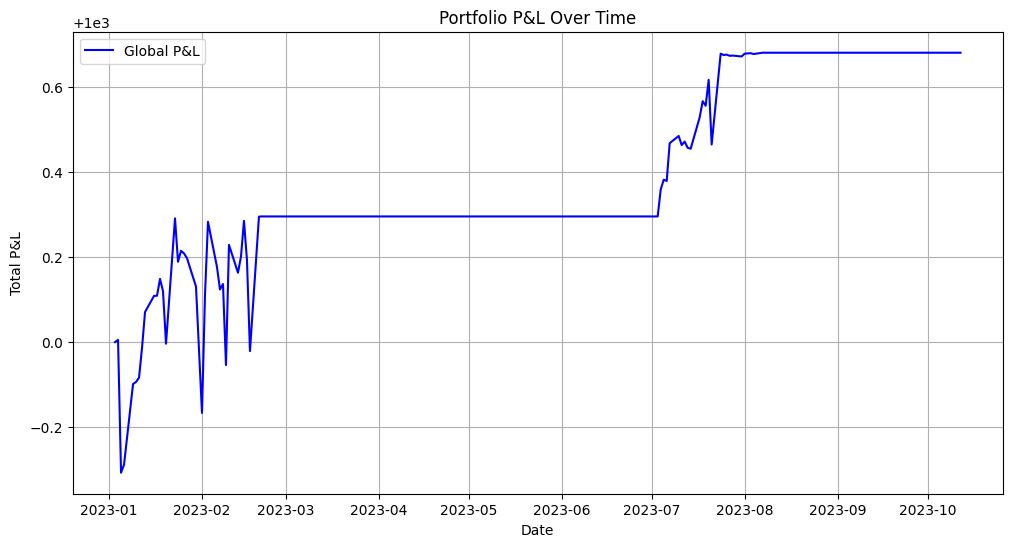

In [34]:
res.plot_pnl()

In [13]:
1e3

1000.0

In [12]:
res.period_pnl

,ref_date,daily_pnl
0,2023-01-04,1000.000000
1,2023-01-05,999.998660
2,2023-01-06,999.999225
3,2023-01-09,1000.000048
4,2023-01-10,1000.000368
...,...,...
193,2023-10-06,1000.005997
194,2023-10-09,1000.005997
195,2023-10-10,1000.005997
196,2023-10-11,1000.005997


In [9]:
aaaa

NameError: name 'aaaa' is not defined

In [ ]:
import pandas as pd
import talib
from enum import Enum
import QuantLib as ql
from market import MarketData
from datetime import date, timedelta
from pricing import *
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'market'

In [ ]:

def get_dates_between(start_date, end_date):
    dates = []
    current_date = start_date
    while current_date <= end_date:
        dates.append(current_date)
        current_date += timedelta(days=1)
    return dates

def history_to_dataframe(history):
    data = {}
    
    for date, market_data in history.items():
        equity_data = market_data.get('equity', {})
        for symbol, values in equity_data.items():
            if symbol not in data:
                data[symbol] = {}
            data[symbol][date] = values.get('price', None)
    
    df = pd.DataFrame(data)
    df.index.name = "Date"
    return df

class Indicator:
    def __init__(self):
        self.methods = {}

    def register(self, name=None):
        """
        A decorator to register an indicator method with a custom or derived name.
        """
        def decorator(func):
            indicator_name = name or func.__name__
            self.methods[indicator_name] = func
            return func
        return decorator

    def compute(self, name, *args, **kwargs):
        """
        Compute the registered indicator.
        """
        if name not in self.methods:
            raise ValueError(f"Indicator '{name}' is not registered.")
        return self.methods[name](*args, **kwargs)
    
class Backtester(ABC):
    def __init__(self, universe, start_date, end_date, starting_balance):
        self.starting_balance = starting_balance
        self.margin = starting_balance
        self.calendar = ql.TARGET()

        market = MarketData(start_date, end_date)
        self.portfolio = Portfolio()
        self.indicator = Indicator()
        self.indicator_symbols = None
        self.indicator_values = {}
        for symbol in universe:
            market.build(symbol)
        self.available_market_data = market.market_data

        self.backtest_dates = get_dates_between(start_date, end_date)
        self.history = {}
        self.ref_dates = []
        self.unprocessed_dates = []
        self.positions_summary = None

    def backtest(self):
        """ chiama in automatico on_data a ogni iterazione e aggiorna history con i valori noti fino alla data"""
        self.positions_summary = pd.DataFrame()
        self.ref_dates = []
        for backtest_date in self.backtest_dates:
            if self.calendar.isHoliday(ql.Date.from_date(backtest_date)):
                continue
            try: 
                self.history[backtest_date] = self.available_market_data[backtest_date]
                # aggiungere if is_valid anche come controllo da far fare in fase di preprocessing
            except:
                self.unprocessed_dates.append(backtest_date)
                continue
            self.ref_dates.append(backtest_date)
            self.on_data()
            summary = pd.DataFrame(self.portfolio.get_positions_summary(self.available_market_data[backtest_date]))
            self.positions_summary = pd.concat([self.positions_summary, summary], axis = 0)
            # funzione che aggiorna il portafoglio in automatico

    def get_data_at(self, ref_date):
        history = {}
        for backtest_date in self.backtest_dates:
            if backtest_date > ref_date:
                break
            if self.calendar.isHoliday(ql.Date.from_date(backtest_date)):
                continue
            try: 
                history[backtest_date] = self.available_market_data[backtest_date]
                # aggiungere if is_valid anche come controllo da far fare in fase di preprocessing
            except:
                continue
        return history
                
    @abstractmethod
    def on_data(self):
        """
        Implement trading logic.
        """
        pass

class OptionTestStrategy(Backtester):
    def __init__(self, universe, start_date, end_date, starting_balance):
        super().__init__(universe, start_date, end_date, starting_balance)

        self.indicator_symbols = 'ctp1'
        self.indicator_values = {}
        self.sma_period = 50
        self.sma_spread = 0.05
        self.otm_pctg = 0.2 # 20%
        self.option_maturity = 30 # days
        self.all_history_prices = history_to_dataframe(self.available_market_data)

        @self.indicator.register("SMA")
        def distance_moving_average(prices: pd.Series):
            ema50 = prices.rolling(window = self.sma_period).mean()
            ema50_distance = (prices - ema50)/prices
            return ema50_distance
        
        self._precompute_indicators()


    def _precompute_indicators(self):
        for key in list(self.indicator.methods.keys()):
            self.indicator_values[key] = pd.DataFrame(self.indicator.compute(key, self.all_history_prices[self.indicator_symbols]))

    def on_data(self):
        ref_date = self.ref_dates[-1] 
        # month_index = ref_date.month
        mkt = self.history[ref_date]
        ctp1_price = self.history[ref_date]['equity']['ctp1']['price']

        sma_50_spread = self.indicator_values['SMA']['ctp1'].loc[:ref_date]

        if sma_50_spread.iloc[-1] > self.sma_spread and sma_50_spread.iloc[-2] < self.sma_spread:
            
            opt_position = OptionPosition(symbol='ctp1',
                            quantity=1,
                            market_data=mkt,
                            strike_price= ctp1_price * (1 + self.otm_pctg),
                            expiry_date=ref_date + timedelta(days=self.option_maturity),
                            option_type=OptionType.CALL, position_type=PositionType.SHORT)
            self.portfolio.add_position(opt_position)

    def buy(self, position: Position):
        if self.margin > position.quantity * position.entry_price:
            self.portfolio.add_position(position)
            self.margin = self.margin - position.quantity * position.entry_price
        else:
            print("No margin available for position")
    


In [ ]:
universe = ['ctp1']
start_date = date(2020, 10, 14)
end_date = date(2023, 10, 12)
starting_balance = 1000

backtester = OptionTestStrategy(universe, start_date, end_date, starting_balance)
backtester.backtest()

# res = ResultAnalyzer(backtester.positions_summary)

NameError: name 'date' is not defined

In [ ]:
res.summary()

{'Expected Return': 0.008248683002795548,
 'Sharpe Ratio': 0.022477495112309086,
 'Win Rate': 1.0,
 'Average P&L': 0.0021548429619467793,
 'Average Win': 0.0021548429619467793,
 'Average Loss': nan,
 'Max Profit': 0.018301221129280554,
 'Max Loss': 0.0,
 'Profit Factor': 1,
 'Max Drawdown': -1.5552937843325156}

In [ ]:
res.get_trade_log()

,ref_date,trade_date,trade_id,symbol,type,side,quantity,entry_price,is_alive,current_value,open_pnl,closed_pnl,global_pnl
0,2021-01-06,2021-01-06,84566,ctp1,option,-1,1,0.001280,True,0.001280,-0.0,0.000000,0.000000
1,2021-02-05,2021-01-06,84566,ctp1,option,-1,0,0.001280,False,0.000000,0.0,0.001280,0.001280
2,2021-02-05,2021-02-05,33347,ctp1,option,-1,1,0.000969,True,0.000969,-0.0,0.000000,0.000000
3,2021-03-08,2021-02-05,33347,ctp1,option,-1,0,0.000969,False,0.000000,0.0,0.000969,0.000969
4,2021-06-02,2021-06-02,36788,ctp1,option,-1,1,0.000933,True,0.000933,-0.0,0.000000,0.000000
5,2021-07-02,2021-06-02,36788,ctp1,option,-1,0,0.000933,False,0.000000,0.0,0.000933,0.000933
6,2021-10-15,2021-10-15,28934,ctp1,option,-1,1,0.000866,True,0.000866,-0.0,0.000000,0.000000
7,2021-11-15,2021-10-15,28934,ctp1,option,-1,0,0.000866,False,0.000000,0.0,0.000866,0.000866
8,2022-01-07,2022-01-07,96268,ctp1,option,-1,1,0.000099,True,0.000099,-0.0,0.000000,0.000000
9,2022-02-07,2022-01-07,96268,ctp1,option,-1,0,0.000099,False,0.000000,0.0,0.000099,0.000099


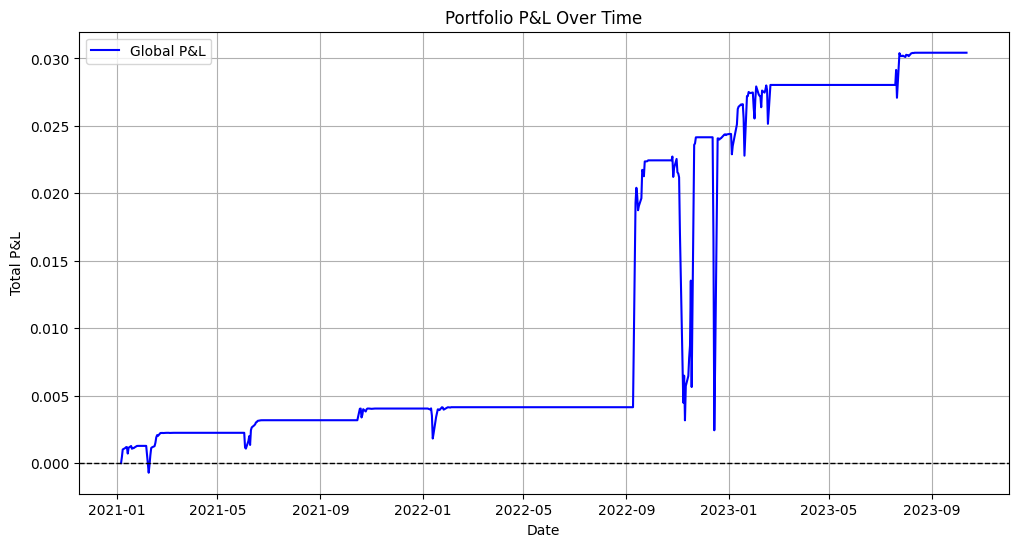

In [ ]:
res.plot_pnl()

In [ ]:
res.max_drawdown()

-1.5552937843325156

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class PortfolioAnalyzer:
    def __init__(self, trades_df, risk_free_rate=0.02):
        """
        Analizza le performance di un portafoglio basato sui trade.

        :param trades_df: DataFrame con i risultati delle posizioni, contenente almeno:
                          - 'ref_date': data di riferimento
                          - 'trade_date': data di apertura
                          - 'trade_id': ID del trade
                          - 'symbol': strumento negoziato
                          - 'entry_price': prezzo di apertura
                          - 'current_value': prezzo attuale
                          - 'closed_pnl': P&L chiuso del trade
                          - 'global_pnl': P&L globale
                          - 'is_alive': True se il trade è aperto, False se chiuso.
        :param risk_free_rate: Tasso di interesse privo di rischio per il calcolo dello Sharpe Ratio.
        """
        self.trades_df = trades_df.copy()
        self.trades_df['ref_date'] = pd.to_datetime(self.trades_df['ref_date'])
        self.trades_df['trade_date'] = pd.to_datetime(self.trades_df['trade_date'])
        self.risk_free_rate = risk_free_rate

    def compute_aggregated_pnl(self):
        """ Calcola il P&L giornaliero aggregato. """
        daily_pnl = self.trades_df.groupby('ref_date')['global_pnl'].sum().reset_index()
        daily_pnl = daily_pnl.rename(columns={'global_pnl': 'daily_pnl'})
        return daily_pnl

    def max_drawdown(self):
        """ Calcola il massimo drawdown del portafoglio. """
        daily_pnl = self.compute_aggregated_pnl()
        pnl_series = daily_pnl['daily_pnl']

        running_max = pnl_series.cummax()
        running_max[running_max == 0] = np.nan  # Evitiamo divisioni per zero
        drawdown = (pnl_series - running_max) / running_max

        return drawdown.min(skipna=True)

    def expected_return(self):
        """ Calcola il rendimento medio giornaliero. """
        daily_pnl = self.compute_aggregated_pnl()
        returns = daily_pnl['daily_pnl'].pct_change().dropna()
        return returns.mean()

    def sharpe_ratio(self):
        """ Calcola lo Sharpe Ratio del portafoglio. """
        daily_pnl = self.compute_aggregated_pnl()
        returns = daily_pnl['daily_pnl'].pct_change().dropna()
        if returns.std() == 0:
            return np.nan
        return (returns.mean() - self.risk_free_rate / 252) / returns.std()

    def win_rate(self):
        """ Calcola la percentuale di trade vincenti. """
        closed_trades = self.trades_df[self.trades_df['is_alive'] == False]
        wins = (closed_trades['closed_pnl'] > 0).sum()
        total = len(closed_trades)
        return wins / total if total > 0 else 0

    def average_pnl(self):
        """ Calcola il profitto medio per trade. """
        closed_trades = self.trades_df[self.trades_df['is_alive'] == False]
        return closed_trades['closed_pnl'].mean()

    def average_win(self):
        """ Calcola il P&L medio dei trade vincenti. """
        closed_trades = self.trades_df[self.trades_df['is_alive'] == False]
        wins = closed_trades[closed_trades['closed_pnl'] > 0]
        return wins['closed_pnl'].mean()

    def average_loss(self):
        """ Calcola il P&L medio dei trade perdenti. """
        closed_trades = self.trades_df[self.trades_df['is_alive'] == False]
        losses = closed_trades[closed_trades['closed_pnl'] < 0]
        return losses['closed_pnl'].mean()

    def max_profit(self):
        """ Trova il trade più redditizio. """
        return self.trades_df['closed_pnl'].max()

    def max_loss(self):
        """ Trova la peggior perdita. """
        return self.trades_df['closed_pnl'].min()

    def profit_factor(self):
        """ Calcola il profit factor (profitto totale / perdita totale). """
        closed_trades = self.trades_df[self.trades_df['is_alive'] == False]
        total_wins = closed_trades[closed_trades['closed_pnl'] > 0]['closed_pnl'].sum()
        total_losses = abs(closed_trades[closed_trades['closed_pnl'] < 0]['closed_pnl'].sum())
        return total_wins / total_losses if total_losses > 0 else np.nan

    def summary(self):
        """ Restituisce un riassunto delle metriche di performance. """
        return {
            "Expected Return": self.expected_return(),
            "Sharpe Ratio": self.sharpe_ratio(),
            "Win Rate": self.win_rate(),
            "Average P&L": self.average_pnl(),
            "Average Win": self.average_win(),
            "Average Loss": self.average_loss(),
            "Max Profit": self.max_profit(),
            "Max Loss": self.max_loss(),
            "Profit Factor": self.profit_factor(),
            "Max Drawdown": self.max_drawdown(),
        }


In [ ]:
res.max_drawdown()

-4.192054893374181

In [ ]:
daily_pnl = res.compute_aggregated_pnl()
pnl_series = daily_pnl['daily_pnl']
running_max = pnl_series.cummax()

In [ ]:
drawdown = (pnl_series - running_max) / running_max  # Drawdown percentuale

In [ ]:
pnl_series

0      0.000000
1     -0.586499
2     -2.152979
3      0.226443
4     -0.283259
         ...   
174    4.412323
175    4.412323
176    4.412323
177    4.412323
178    4.412323
Name: daily_pnl, Length: 179, dtype: float64

In [ ]:
trades_df.iloc[-10:]

,ref_date,trade_date,trade_id,symbol,type,side,quantity,entry_price,is_alive,current_value,open_pnl,closed_pnl,global_pnl
0,2023-10-06,2023-01-31,89190,ctp1,option,-1,0,0.000058,False,0.0,0.0,0.577945,0.577945
1,2023-10-06,2023-02-06,11458,ctp1,option,-1,0,0.000383,False,0.0,0.0,3.834378,3.834378
0,2023-10-09,2023-01-31,89190,ctp1,option,-1,0,0.000058,False,0.0,0.0,0.577945,0.577945
1,2023-10-09,2023-02-06,11458,ctp1,option,-1,0,0.000383,False,0.0,0.0,3.834378,3.834378
0,2023-10-10,2023-01-31,89190,ctp1,option,-1,0,0.000058,False,0.0,0.0,0.577945,0.577945
1,2023-10-10,2023-02-06,11458,ctp1,option,-1,0,0.000383,False,0.0,0.0,3.834378,3.834378
0,2023-10-11,2023-01-31,89190,ctp1,option,-1,0,0.000058,False,0.0,0.0,0.577945,0.577945
1,2023-10-11,2023-02-06,11458,ctp1,option,-1,0,0.000383,False,0.0,0.0,3.834378,3.834378
0,2023-10-12,2023-01-31,89190,ctp1,option,-1,0,0.000058,False,0.0,0.0,0.577945,0.577945
1,2023-10-12,2023-02-06,11458,ctp1,option,-1,0,0.000383,False,0.0,0.0,3.834378,3.834378


In [ ]:
0.577945 + 3.834378

4.412323

In [ ]:
backtester.all_history_prices.loc[date(2022, 10, 27)]

ctp1    1.9058
Name: 2022-10-27, dtype: float64

In [ ]:
backtester.all_history_prices.loc[date(2023,10,10)]

ctp1    2.425
Name: 2023-10-10, dtype: float64

In [ ]:
backtester.indicator_values['SMA'] 

,ctp1
Date,
2022-10-14,NaN
2022-10-17,NaN
2022-10-18,NaN
2022-10-19,NaN
2022-10-20,NaN
...,...
2023-10-06,-0.023868
2023-10-09,-0.032678
2023-10-10,-0.010342


In [ ]:
all_history_prices = history_to_dataframe(backtester.available_market_data)
for key in list(backtester.indicator.methods.keys()):
    backtester.indicator_values[key] = backtester.indicator.compute(key, all_history_prices[backtester.indicator_symbols], window=3)

TypeError: distance_moving_average() got an unexpected keyword argument 'window'

In [ ]:
backtester.indicator_values

{'SMA': Date
 2022-10-14         NaN
 2022-10-17         NaN
 2022-10-18    1.752733
 2022-10-19    1.779133
 2022-10-20    1.807800
                 ...   
 2023-10-06    2.376000
 2023-10-09    2.380667
 2023-10-10    2.401000
 2023-10-11    2.414833
 2023-10-12    2.438500
 Name: ctp1, Length: 255, dtype: float64}

In [ ]:
aaa

In [ ]:
all_history_prices[backtester.indicator_symbols]

Date
2022-10-14    1.7124
2022-10-17    1.7430
2022-10-18    1.8028
2022-10-19    1.7916
2022-10-20    1.8290
               ...  
2023-10-06    2.4015
2023-10-09    2.3765
2023-10-10    2.4250
2023-10-11    2.4430
2023-10-12    2.4475
Name: ctp1, Length: 255, dtype: float64

In [ ]:
pd.DataFrame(backtester.indicator_values['SMA']['ctp1'])

,ctp1
Date,
2022-10-14,NaN
2022-10-17,NaN
2022-10-18,1.752733
2022-10-19,1.779133
2022-10-20,1.807800
...,...
2023-10-06,2.376000
2023-10-09,2.380667
2023-10-10,2.401000


In [ ]:
df

,ref_date,equity,rate,volatility
2022-10-14,2022-10-14,"{'ctp1': {'price': 1.7124, 'div_yield': 0.05, ...",{'riskfree': 0.03},{'ctp1': <QuantLib.QuantLib.BlackVarianceSurfa...
2022-10-17,2022-10-17,"{'ctp1': {'price': 1.743, 'div_yield': 0.05, '...",{'riskfree': 0.03},{'ctp1': <QuantLib.QuantLib.BlackVarianceSurfa...
2022-10-18,2022-10-18,"{'ctp1': {'price': 1.8028, 'div_yield': 0.05, ...",{'riskfree': 0.03},{'ctp1': <QuantLib.QuantLib.BlackVarianceSurfa...
2022-10-19,2022-10-19,"{'ctp1': {'price': 1.7916, 'div_yield': 0.05, ...",{'riskfree': 0.03},{'ctp1': <QuantLib.QuantLib.BlackVarianceSurfa...
2022-10-20,2022-10-20,"{'ctp1': {'price': 1.829, 'div_yield': 0.05, '...",{'riskfree': 0.03},{'ctp1': <QuantLib.QuantLib.BlackVarianceSurfa...
...,...,...,...,...
2023-10-06,2023-10-06,"{'ctp1': {'price': 2.4015, 'div_yield': 0.05, ...",{'riskfree': 0.03},{'ctp1': <QuantLib.QuantLib.BlackVarianceSurfa...
2023-10-09,2023-10-09,"{'ctp1': {'price': 2.3765, 'div_yield': 0.05, ...",{'riskfree': 0.03},{'ctp1': <QuantLib.QuantLib.BlackVarianceSurfa...
2023-10-10,2023-10-10,"{'ctp1': {'price': 2.425, 'div_yield': 0.05, '...",{'riskfree': 0.03},{'ctp1': <QuantLib.QuantLib.BlackVarianceSurfa...
2023-10-11,2023-10-11,"{'ctp1': {'price': 2.443, 'div_yield': 0.05, '...",{'riskfree': 0.03},{'ctp1': <QuantLib.QuantLib.BlackVarianceSurfa...


In [ ]:
0.424397 * 2

0.848794

In [ ]:
(0.476331 - 0.200143) * 1

0.276188

In [ ]:
(2.425 - 1.9)*1

0.5249999999999999

In [ ]:
backtester.history[date(2022, 10, 27)]

{'ref_date': datetime.date(2022, 10, 27),
 'equity': {'ctp1': {'price': 1.9058, 'div_yield': 0.05, 'is_valid': True}},
 'rate': {'riskfree': 0.03},
 'volatility': {'ctp1': <QuantLib.QuantLib.BlackVarianceSurface; proxy of <Swig Object of type 'ext::shared_ptr< BlackVarianceSurface > *' at 0x0000016F6064D180> >}}

In [ ]:
backtester.history[date(2023, 10, 10)]

{'ref_date': datetime.date(2023, 10, 10),
 'equity': {'ctp1': {'price': 2.425, 'div_yield': 0.05, 'is_valid': True}},
 'rate': {'riskfree': 0.03},
 'volatility': {'ctp1': <QuantLib.QuantLib.BlackVarianceSurface; proxy of <Swig Object of type 'ext::shared_ptr< BlackVarianceSurface > *' at 0x0000016F033432D0> >}}

In [ ]:
OptionPosition(symbol='ctp1',
               quantity=2,
               )

TypeError: __init__() missing 5 required positional arguments: 'market_data', 'strike_price', 'expiry_date', 'option_type', and 'position_type'

In [ ]:
opt_position = OptionPosition(symbol,
               5,
               entry_mkt,
               strike_price,
               expiry_date,
               option_type,
               position_type)